### 0. Import util libraries

In [2]:
import numpy as np
import torch
torch.manual_seed(123)
from scipy import interpolate
import random
from scipy.integrate import solve_ivp

# helmholtz gp imports
import helmholtz_gp.helmholtz_regression_pytorch as hrp
import helmholtz_gp.plot_helper_arxiv as plot_helm
from helmholtz_gp.parameters import TwoKernelGPParams
from helmholtz_gp.optimization_loop import basic_optimization_loop

# d-hnn imports
import dissipative_hnns
from dissipative_hnns.models import MLP, DHNN, HNN
from dissipative_hnns.train import train, get_args

# set plotting params for the notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [20, 10]
mpl.rcParams['figure.dpi'] = 300
np.set_printoptions(precision=5)
from matplotlib import cm
plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Times"],
            "font.size": 12,
        }
    )

### 1. Import the data

In [3]:
X_grid = np.genfromtxt('../data/Xgrid_duffing_divsmall.csv', delimiter=',')
Y_grid = np.genfromtxt('../data/Ygrid_duffing_divsmall.csv', delimiter=',')
XY_train = torch.from_numpy(np.genfromtxt('../data/XY_train_duffing_divsmall.csv', delimiter=','))
XY_test = torch.from_numpy(np.genfromtxt('../data/XY_test_duffing_divsmall.csv', delimiter=','))
UV_train = torch.from_numpy(np.genfromtxt('../data/UV_train_duffing_divsmall.csv', delimiter=','))
UV_test = torch.from_numpy(np.genfromtxt('../data/UV_test_duffing_divsmall.csv', delimiter=','))
div_grid = np.genfromtxt('../data/divgrid_duffing_divsmall.csv', delimiter=',')
vort_grid = np.genfromtxt('../data/vortgrid_duffing_divsmall.csv', delimiter=',')

### 2. Visualize the data

We first visualize the imported data. In the first column we have the underlying vector field, in black, and the simulated buoys traces, in red, that we will use as training data. In the second column we plot the ground truth divergence, in this case 0 everywhere. The third column represents the ground truth vorticity, -2 everywhere. 

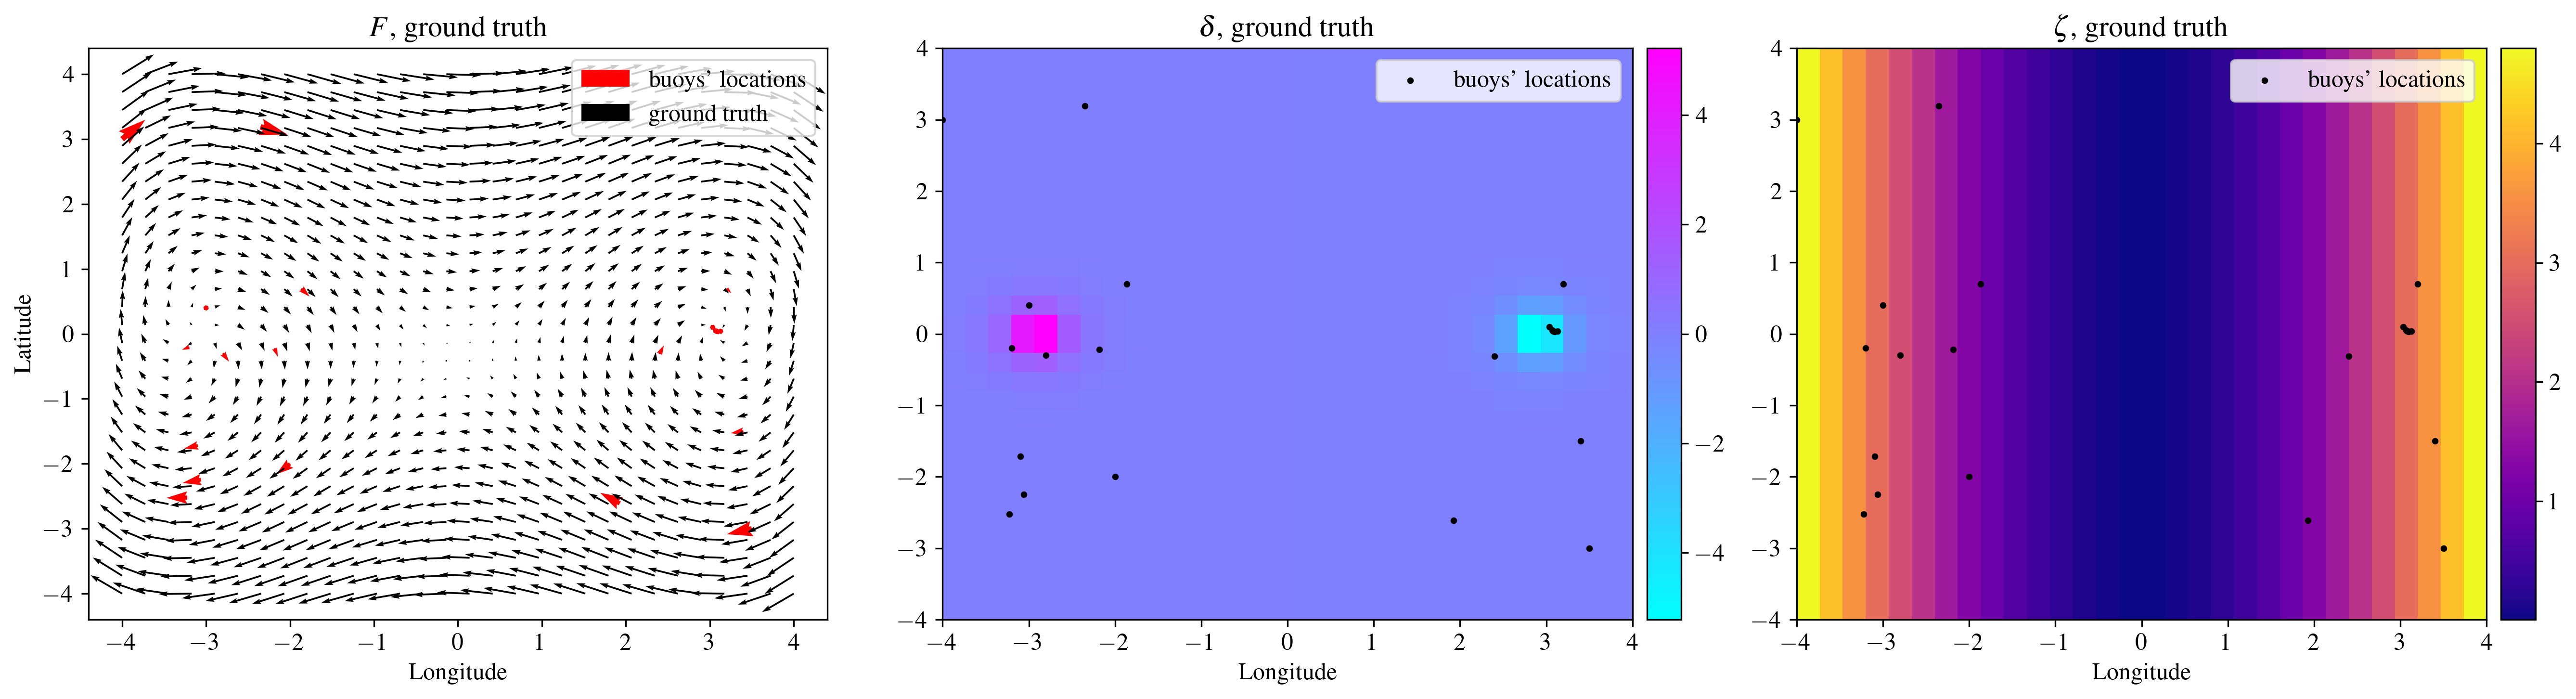

In [4]:
plot_helm.visualize_data(X_grid, Y_grid, XY_train, UV_train, XY_test, UV_test, vort_grid, div_grid, scale=10)

### 3. Fit the Helmholtz GP 

We first fit the Helmholtz GP. The parameters are optimized on the log-scale, as follows. The loss function is the negative log-likelihood of the training points. 

Optimizer for GP:

In [5]:
log_ls_Phi = torch.tensor(0., requires_grad=True) 
log_sigma_Phi = torch.tensor(0., requires_grad=True)
log_ls_A = torch.tensor(1., requires_grad=True)
log_sigma_A = torch.tensor(-1., requires_grad=True) 
log_obs_noise_helm = torch.tensor(-2., requires_grad=True)

params_helm = [log_ls_Phi,log_sigma_Phi,log_ls_A,log_sigma_A,log_obs_noise_helm]
params_helm = TwoKernelGPParams(*params_helm)

def loss_helm(params_helm):
    return -hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, kind = "helmholtz", params=params_helm)[2][0,0]

In [6]:
basic_optimization_loop(loss_helm, params_helm)

At step 0, loss: 51.68852199945468
At step 100, loss: 0.7252369765394455
At step 200, loss: -15.593646125097912
At step 300, loss: -28.194498310990895
At step 400, loss: -30.79579381266118
At step 500, loss: -31.463084231652118
At step 600, loss: -31.641900860888448
At step 700, loss: -31.679121248692795


We can show the optimal parameters:

In [7]:
best_params_helm = params_helm.get_params()
best_params_helm

[tensor(0.6335, grad_fn=<ExpBackward0>),
 tensor(0.3734, grad_fn=<ExpBackward0>),
 tensor(3.9115, grad_fn=<ExpBackward0>),
 tensor(6.9294, grad_fn=<ExpBackward0>),
 tensor(0.0083, grad_fn=<ExpBackward0>)]

We visualize the predicted mean and covariance:

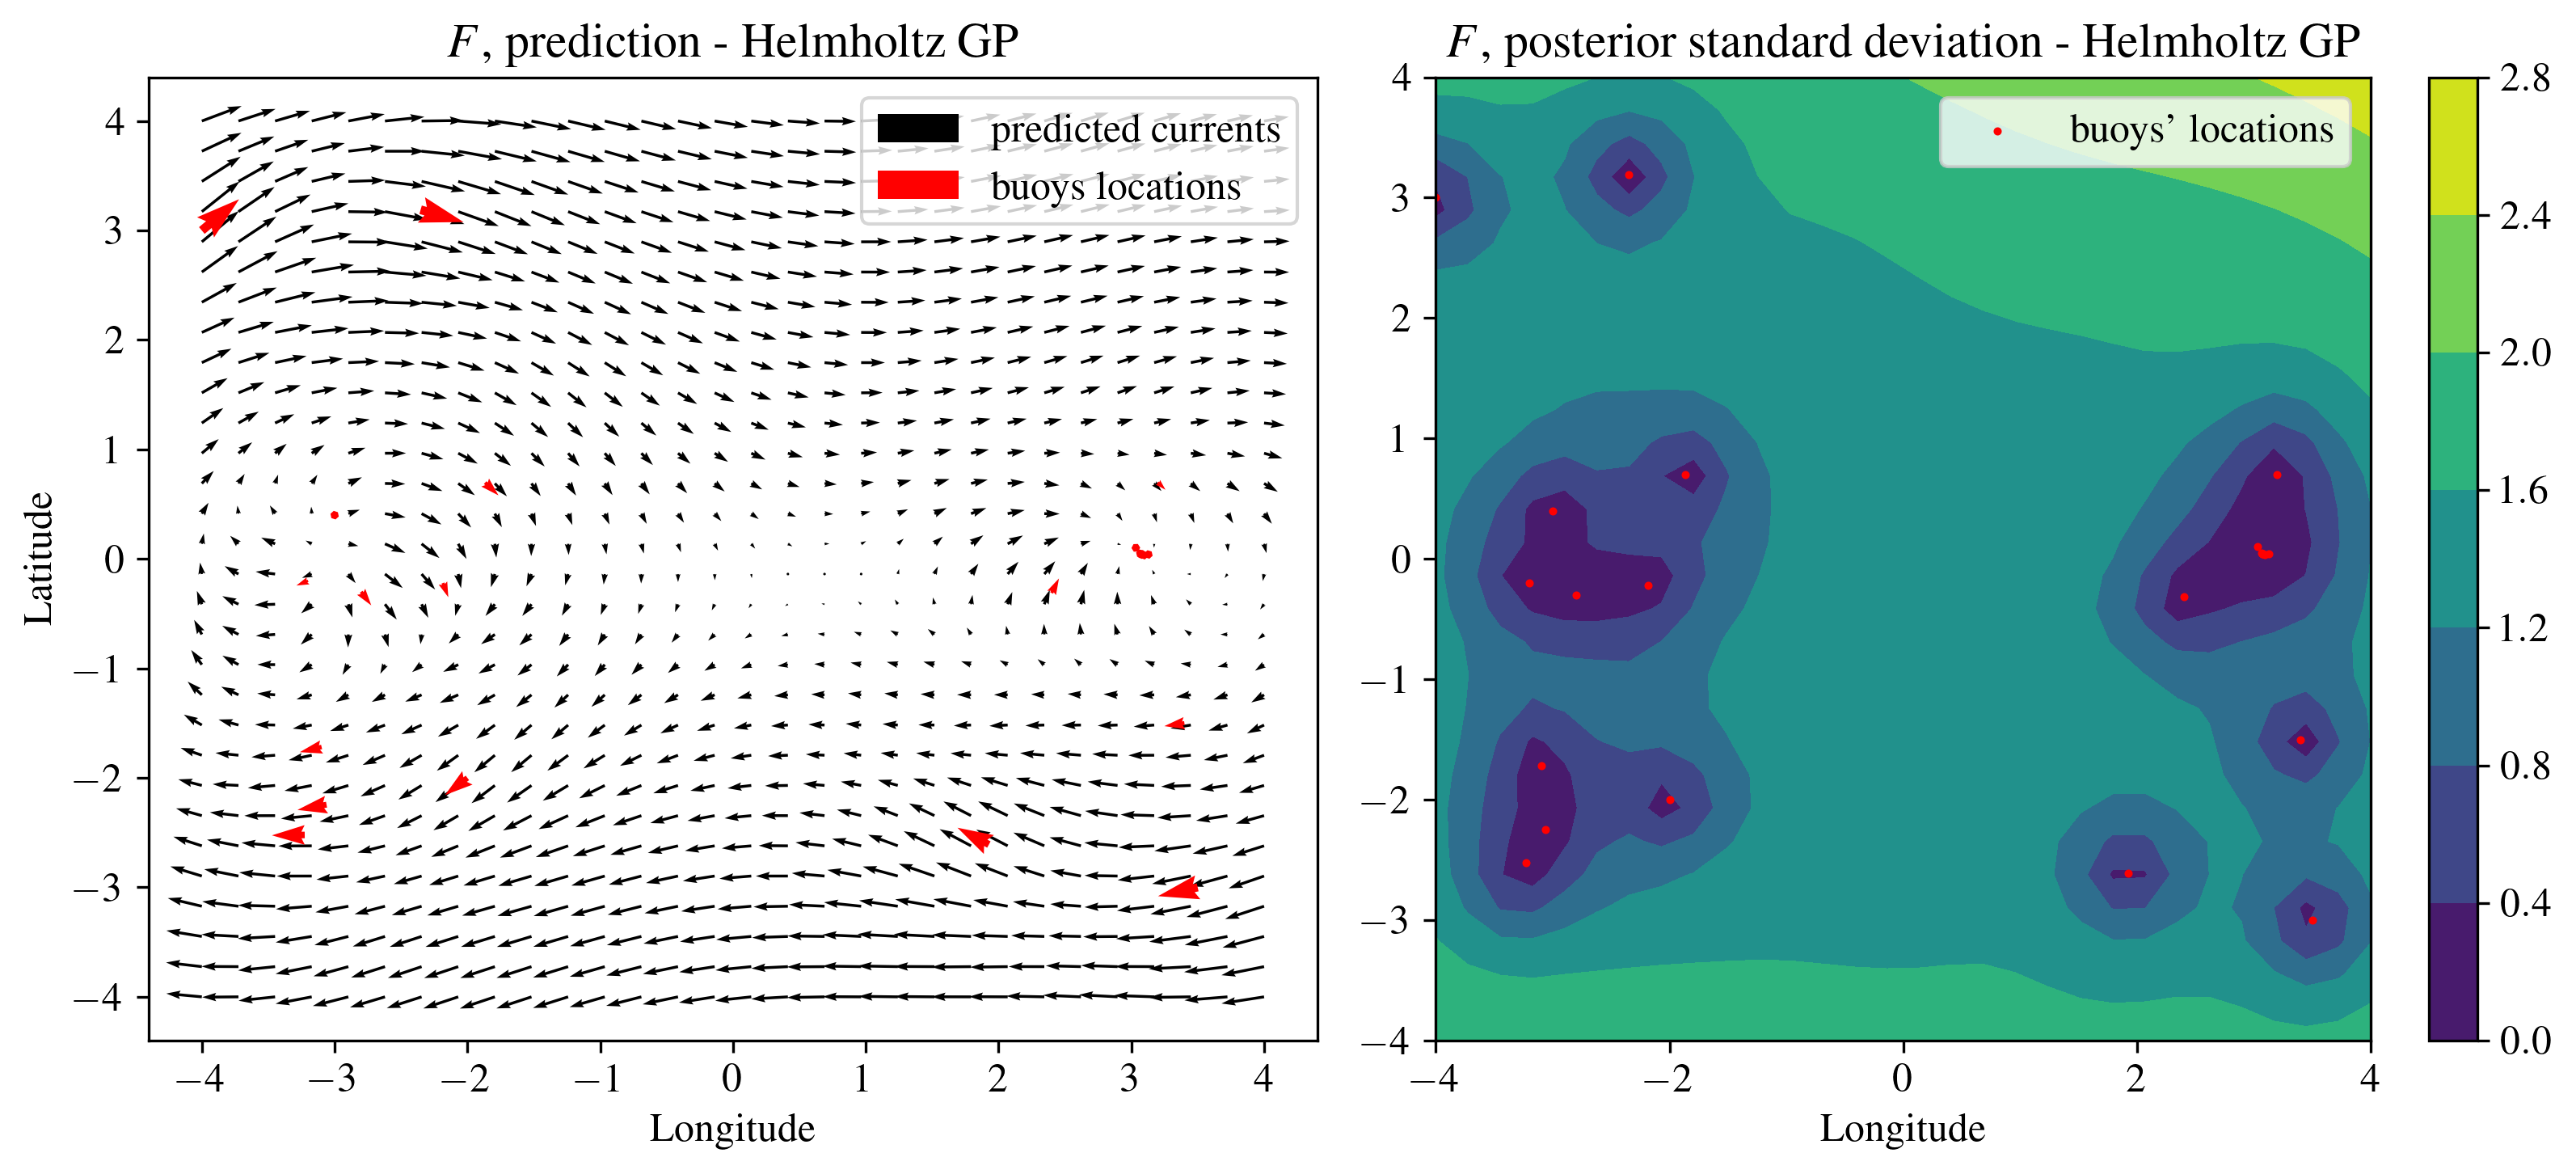

In [8]:
opt_post_mean_helm, opt_post_cov_helm, opt_ll_helm = hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, "helmholtz", params_helm)

plot_helm.plot_results_grid(X_grid, Y_grid, XY_train, UV_train, opt_post_mean_helm, opt_post_cov_helm, levels="", scale=10, method="Helmholtz GP")


### 4. Fit velocity GP regression

We then fit the velocity GP, in a similar way.

In [9]:
log_ls_u = torch.tensor(0., requires_grad=True) 
log_sigma_u = torch.tensor(0., requires_grad=True)
log_ls_v = torch.tensor(1., requires_grad=True)
log_sigma_v = torch.tensor(-1., requires_grad=True) 
log_obs_noise_uv = torch.tensor(-2., requires_grad=True)

params_uv = [log_ls_u,log_sigma_u,log_ls_v,log_sigma_v,log_obs_noise_uv]
params_uv = TwoKernelGPParams(*params_uv)

def loss_uv(params_uv):
    return -hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, kind = "standard", params=params_uv)[2][0,0]

In [10]:
basic_optimization_loop(loss_uv, params_uv)

At step 0, loss: 59.72238914760267
At step 100, loss: 2.3672559685150247
At step 200, loss: -9.196862649925784
At step 300, loss: -15.432127935349904
At step 400, loss: -18.393035782446965
At step 500, loss: -18.84618947103992


In [11]:
best_params_uv = params_uv.get_params()
best_params_uv

[tensor(0.7212, grad_fn=<ExpBackward0>),
 tensor(1.8767, grad_fn=<ExpBackward0>),
 tensor(2.7183, grad_fn=<ExpBackward0>),
 tensor(1.1361, grad_fn=<ExpBackward0>),
 tensor(0.0084, grad_fn=<ExpBackward0>)]

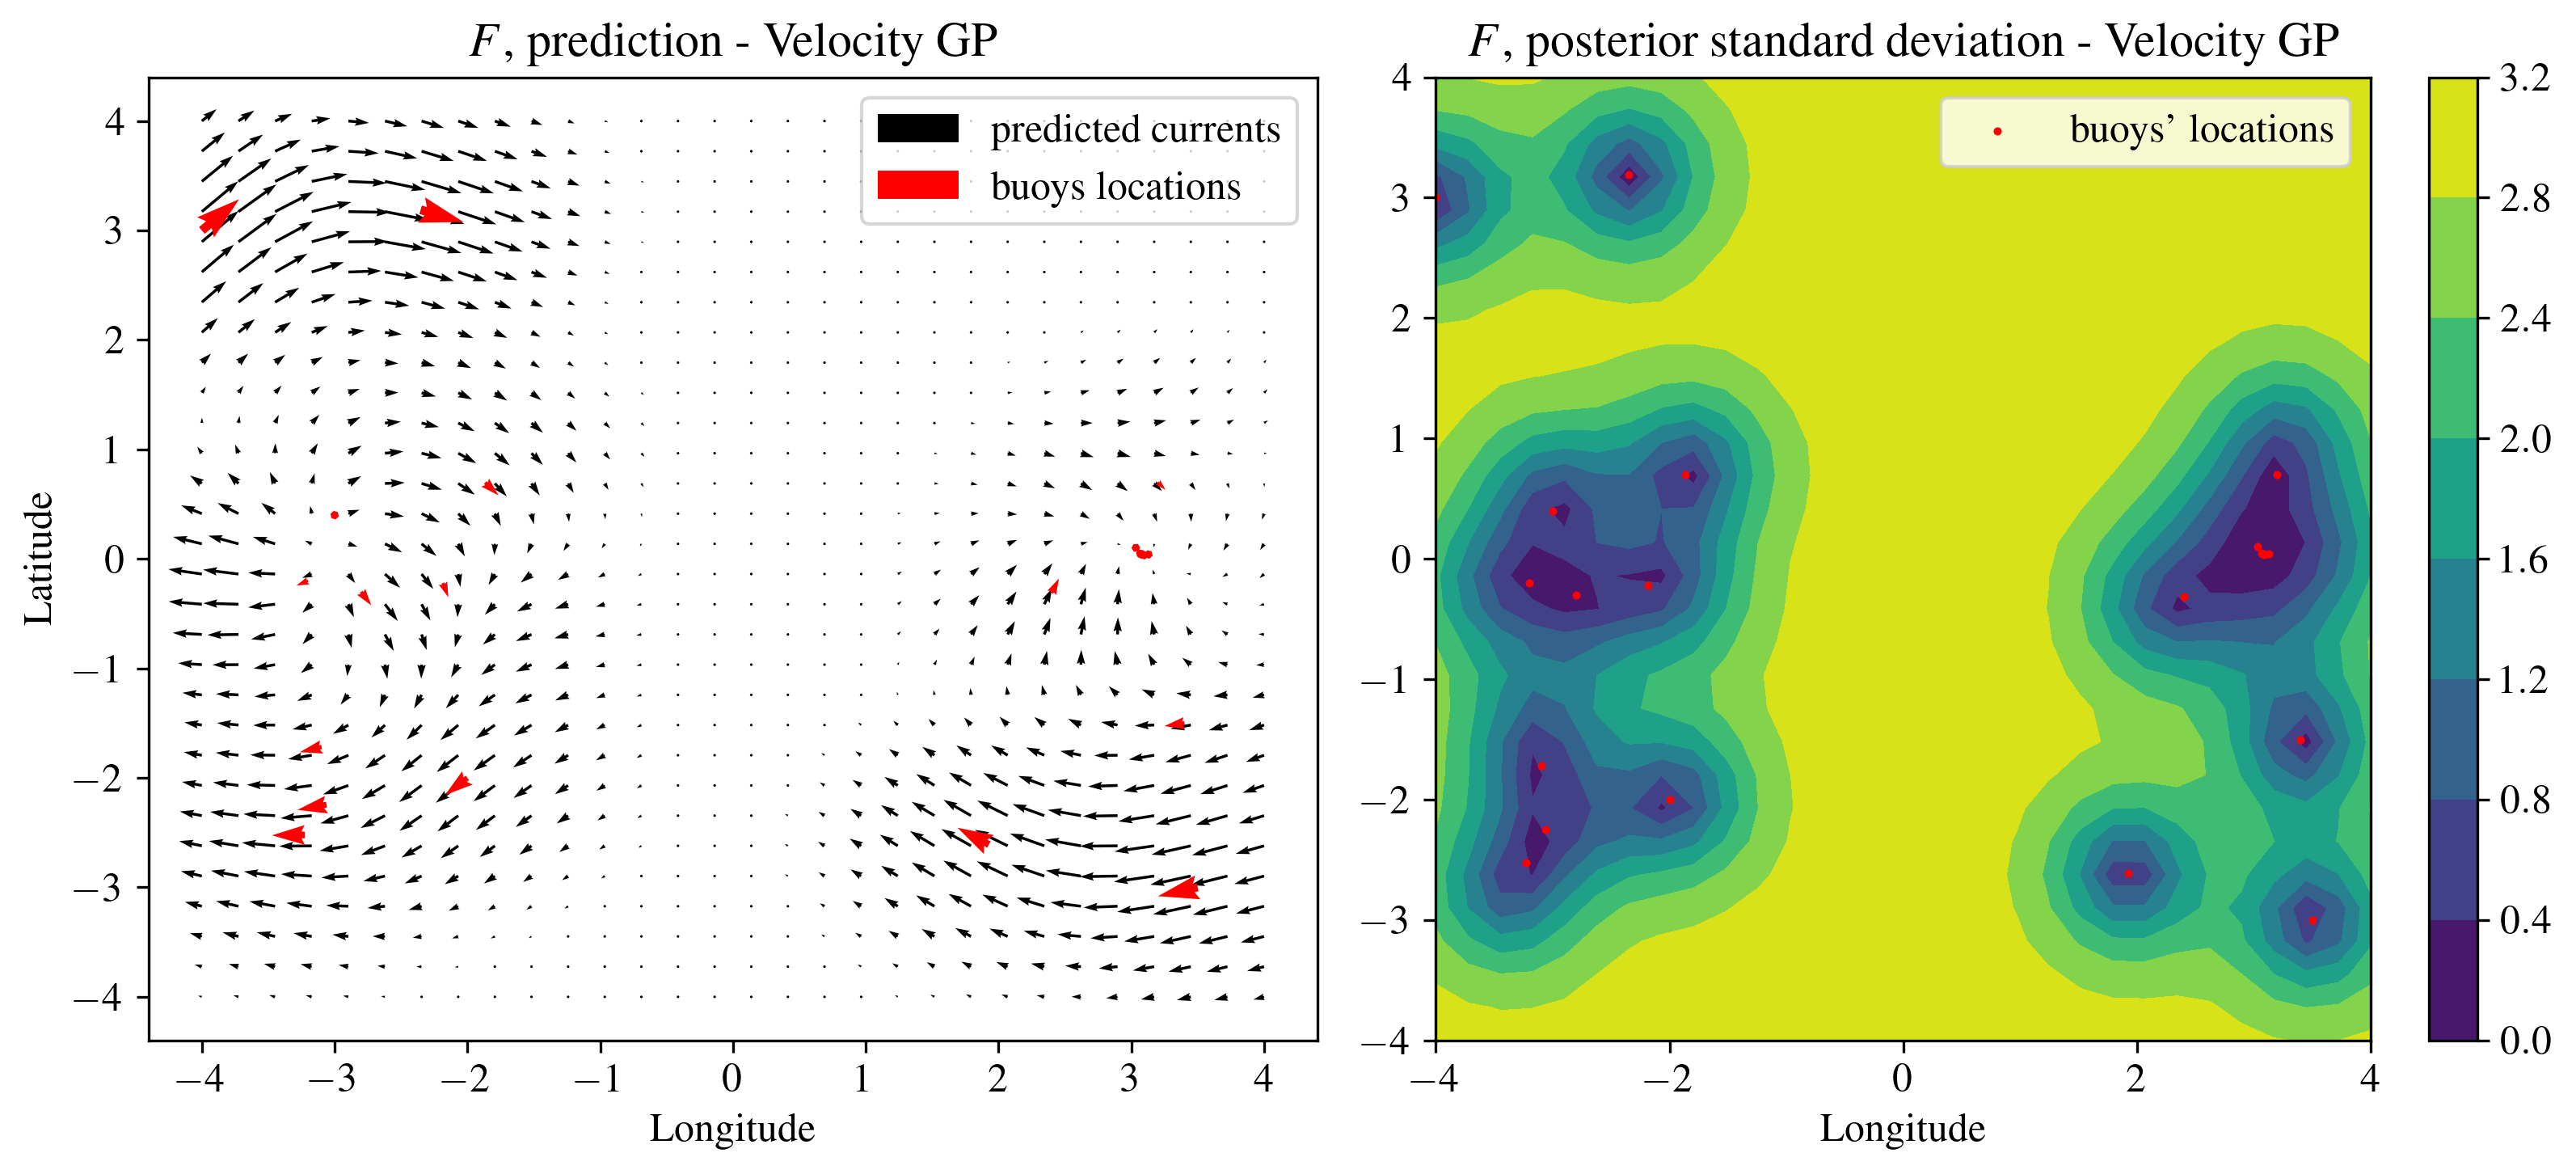

In [12]:
opt_post_mean_uv, opt_post_cov_uv, opt_ll_uv = hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, "standard", params_uv)

plot_helm.plot_results_grid(X_grid, Y_grid, XY_train, UV_train, opt_post_mean_uv, opt_post_cov_uv, levels=False, scale=10, method="Velocity GP")


### 5. Visually compare velocity field predictions

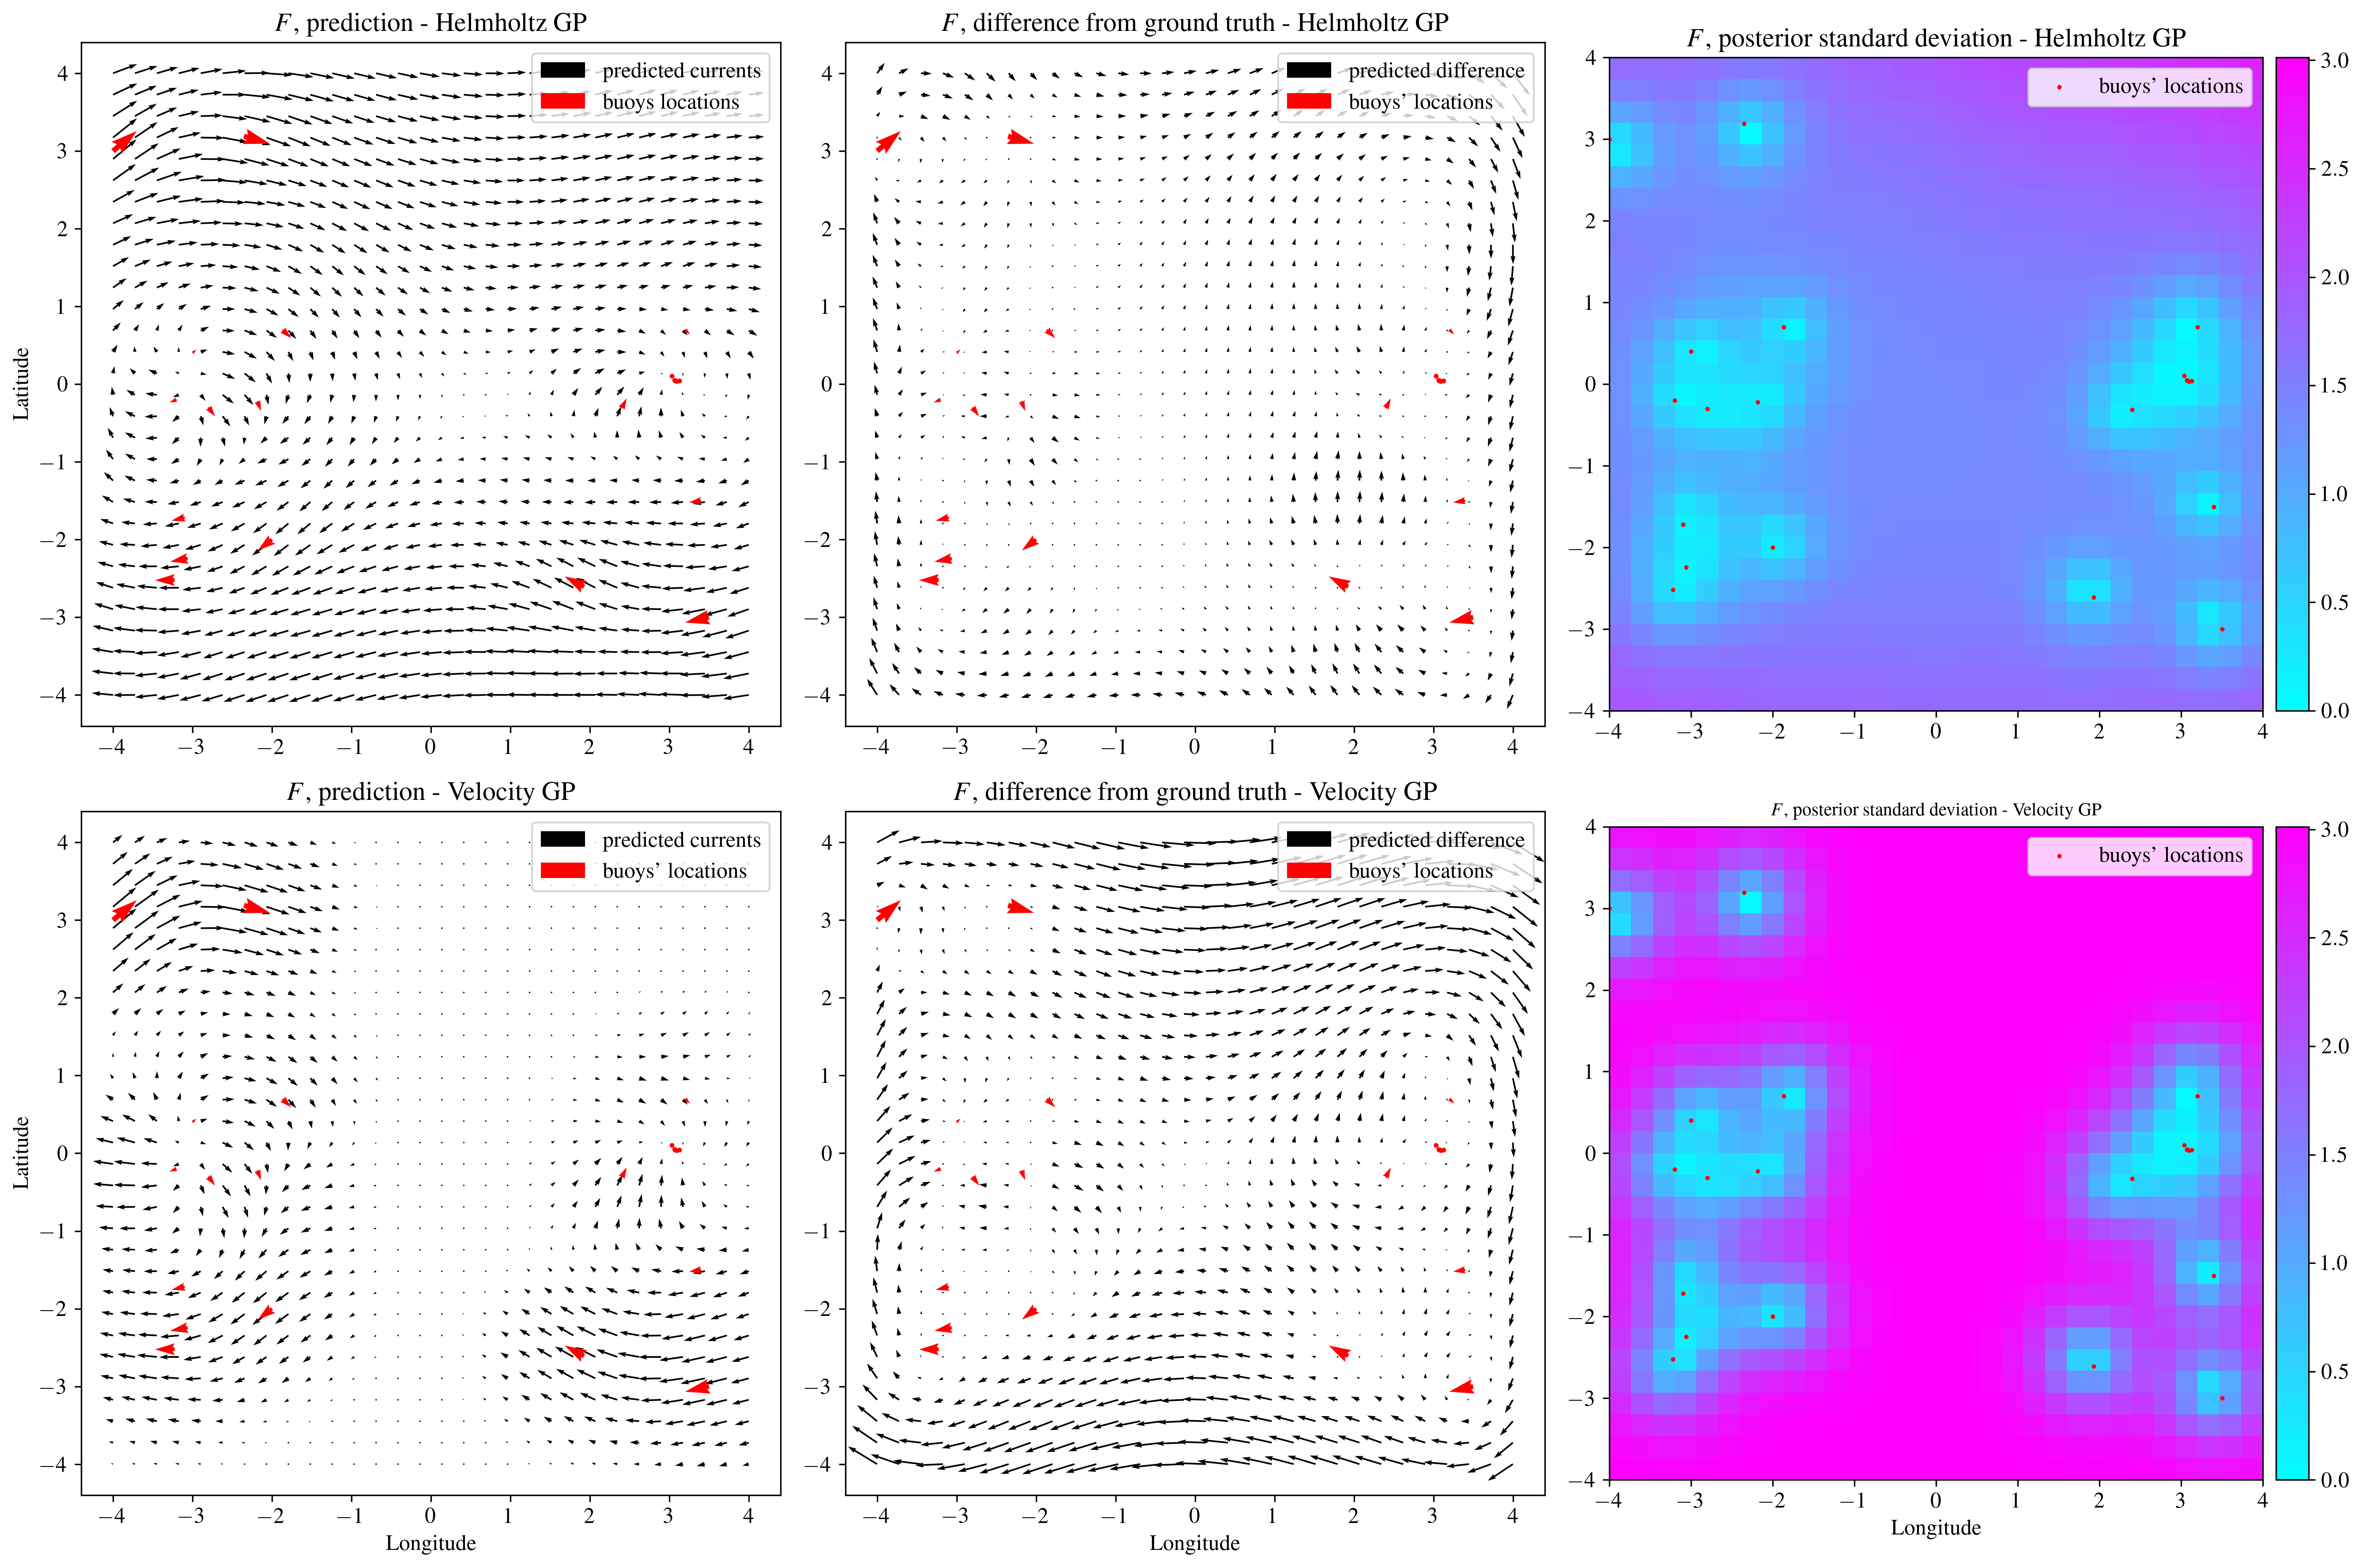

In [13]:
plot_helm.plot_results_comparison(X_grid, Y_grid, XY_train, UV_train, UV_test, 
                                opt_post_mean_helm, opt_post_cov_helm,
                                opt_post_mean_uv, opt_post_cov_uv,
                                scale=10, cmap='cool')
                            

### 6. Posterior divergence analysis

We compute the posterior divergence for both methods, and we visually compare the predictions, uncertainty, and z-values.

In [14]:
div_mean_helm, div_var_helm = hrp.posterior_divergence_forloop_diffphi(XY_test, XY_train, UV_train, params_helm)
div_mean_std, div_var_std = hrp.posterior_divergence_forloop(XY_test, XY_train, UV_train, "standard", params_uv)

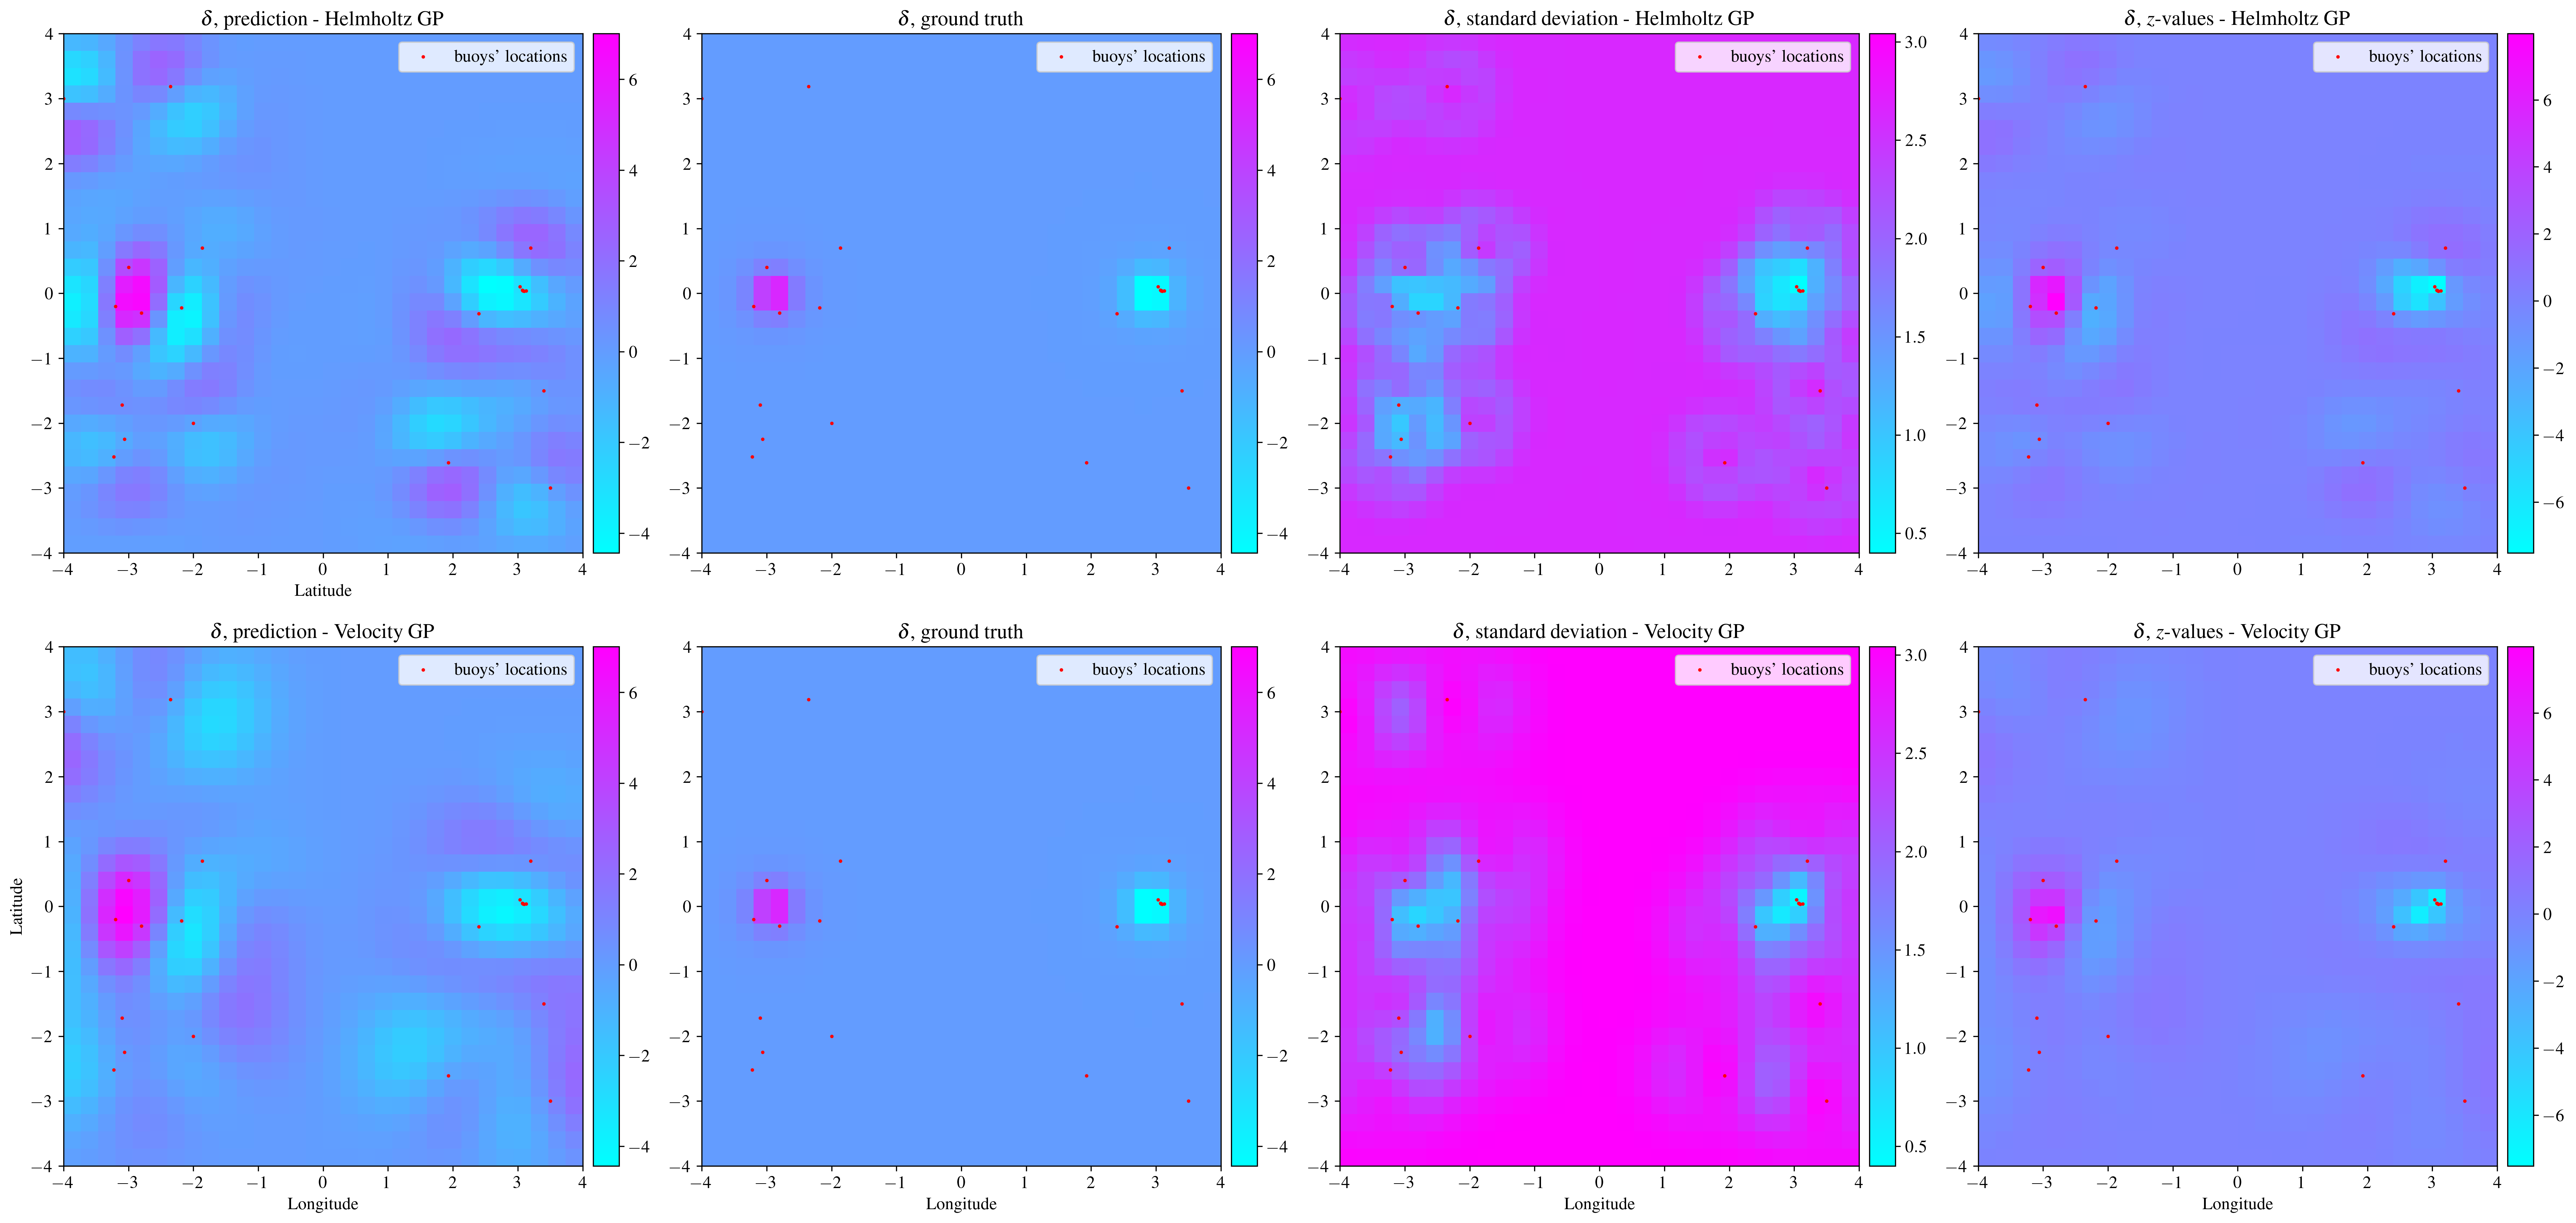

In [15]:
plot_helm.plot_scalarfield_comparison(X_grid, Y_grid, XY_train, div_grid,
                                    div_mean_helm, div_var_helm,
                                    div_mean_std, div_var_std, 
                                    component="$\delta$", cmap='cool')

### 7. Compute posterior vorticity

Similarly we compute the vorticity and plot the results.

In [16]:
vort_mean_helm, vort_var_helm = hrp.posterior_vorticity_forloop_diffpsi(XY_test, XY_train, UV_train, params_helm)
vort_mean_std, vort_var_std = hrp.posterior_vorticity_forloop(XY_test, XY_train, UV_train, "standard", params_uv)

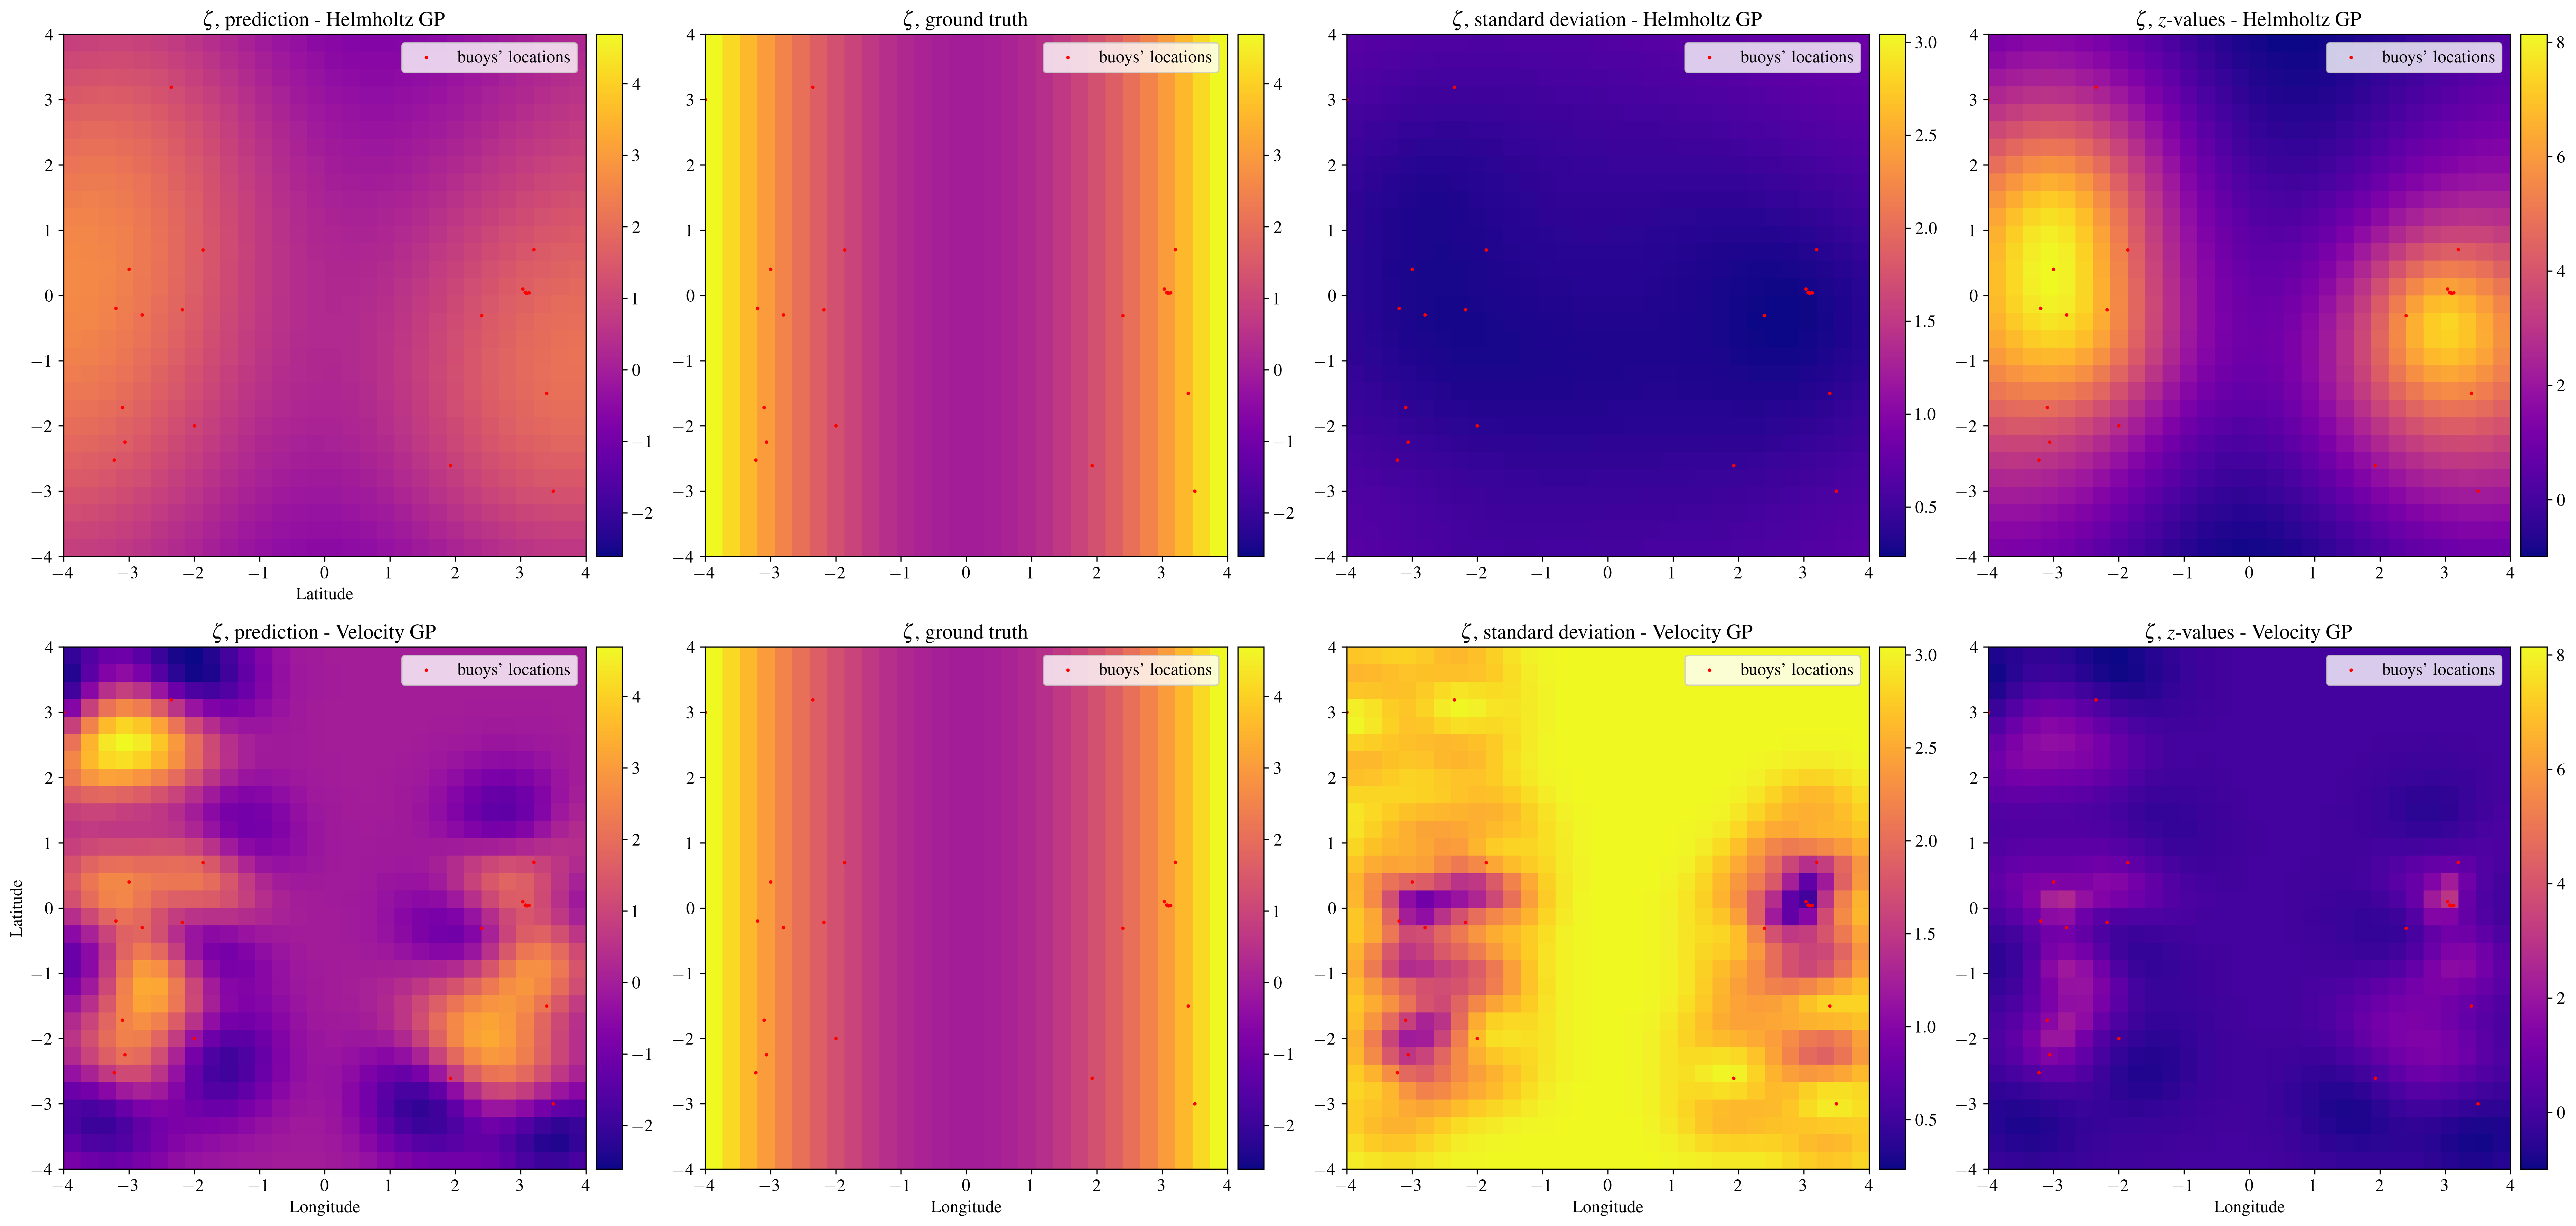

In [17]:
plot_helm.plot_scalarfield_comparison(X_grid, Y_grid, XY_train, vort_grid,
                                    vort_mean_helm, vort_var_helm,
                                    vort_mean_std, vort_var_std, 
                                    component="$\zeta$", cmap='plasma')

### 8. Get D-HNN predictions

Next, we can get the same set of results with the dissipative Hamiltonian neural network (D-HNN) approach

In [18]:
data = {'x':XY_train,
       'x_test':XY_test,
       't':np.reshape(np.ones(XY_train.shape[0]).T, [-1,1]),
       't_test':np.reshape(np.ones(XY_test.shape[0]).T, [-1,1]),
       'dx':UV_train, 
       'dx_test':UV_test
       }

In [19]:
args = get_args()
args.learning_rate = 3e-5
args.total_steps = 50000
args.eval_every = args.print_every = 1000

args.input_dim = 3
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
dhnn_model = DHNN(args.input_dim, args.hidden_dim)
dhnn_results = train(dhnn_model, args, data)  # training the model

/Users/renb/Desktop/helmholtz_torch_local/dissipative_hnns/train.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(v_batch, requires_grad=True,  dtype=torch.float32, device=args.device)


step 0, dt 0.007, train_loss 1.68e+00, test_loss 6.52e+00
step 1000, dt 1.992, train_loss 3.65e-01, test_loss 3.10e+00
step 2000, dt 1.501, train_loss 6.97e-02, test_loss 3.27e+00
step 3000, dt 1.942, train_loss 2.74e-02, test_loss 3.66e+00
step 4000, dt 2.185, train_loss 1.11e-04, test_loss 3.99e+00
step 5000, dt 1.777, train_loss 1.46e-02, test_loss 4.20e+00
step 6000, dt 1.798, train_loss 3.26e-03, test_loss 4.42e+00
step 7000, dt 1.867, train_loss 1.77e-04, test_loss 4.58e+00
step 8000, dt 1.662, train_loss 5.04e-05, test_loss 4.53e+00
step 9000, dt 1.570, train_loss 1.32e-05, test_loss 4.43e+00
step 10000, dt 1.528, train_loss 2.06e-04, test_loss 4.35e+00
step 11000, dt 1.574, train_loss 7.89e-05, test_loss 4.25e+00
step 12000, dt 1.446, train_loss 3.70e-05, test_loss 4.17e+00
step 13000, dt 1.477, train_loss 9.68e-05, test_loss 4.09e+00
step 14000, dt 1.499, train_loss 9.49e-04, test_loss 4.02e+00
step 15000, dt 1.483, train_loss 3.90e-05, test_loss 3.95e+00
step 16000, dt 1.538,

In [20]:
##Visualize results
[x, x_test, t, t_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32)
               for v in ['x', 'x_test','t', 't_test']]

#compute predictions at test points
y_hat_irr_test, y_hat_rot_test = dhnn_model(x_test, t=t_test, as_separate=True)
y_hat_test = y_hat_rot_test + y_hat_irr_test

#divergence at test point
divergence_x = torch.autograd.grad(y_hat_irr_test[:,0].sum(), x_test, create_graph=True)[0][:,0]
divergence_y = torch.autograd.grad(y_hat_irr_test[:,1].sum(), x_test, create_graph=True)[0][:,1]
divergence_dhnn = divergence_x + divergence_y

#vorticity at test point
vorticity_x = torch.autograd.grad(y_hat_rot_test[:,0].sum(), x_test, create_graph=True)[0][:,1]
vorticity_y = torch.autograd.grad(y_hat_rot_test[:,1].sum(), x_test, create_graph=True)[0][:,0]
vorticity_dhnn = vorticity_x - vorticity_y

/var/folders/xd/gc1qb67x67gbhkz1mmb7vbg40000gn/T/ipykernel_39002/4211146855.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [x, x_test, t, t_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32)


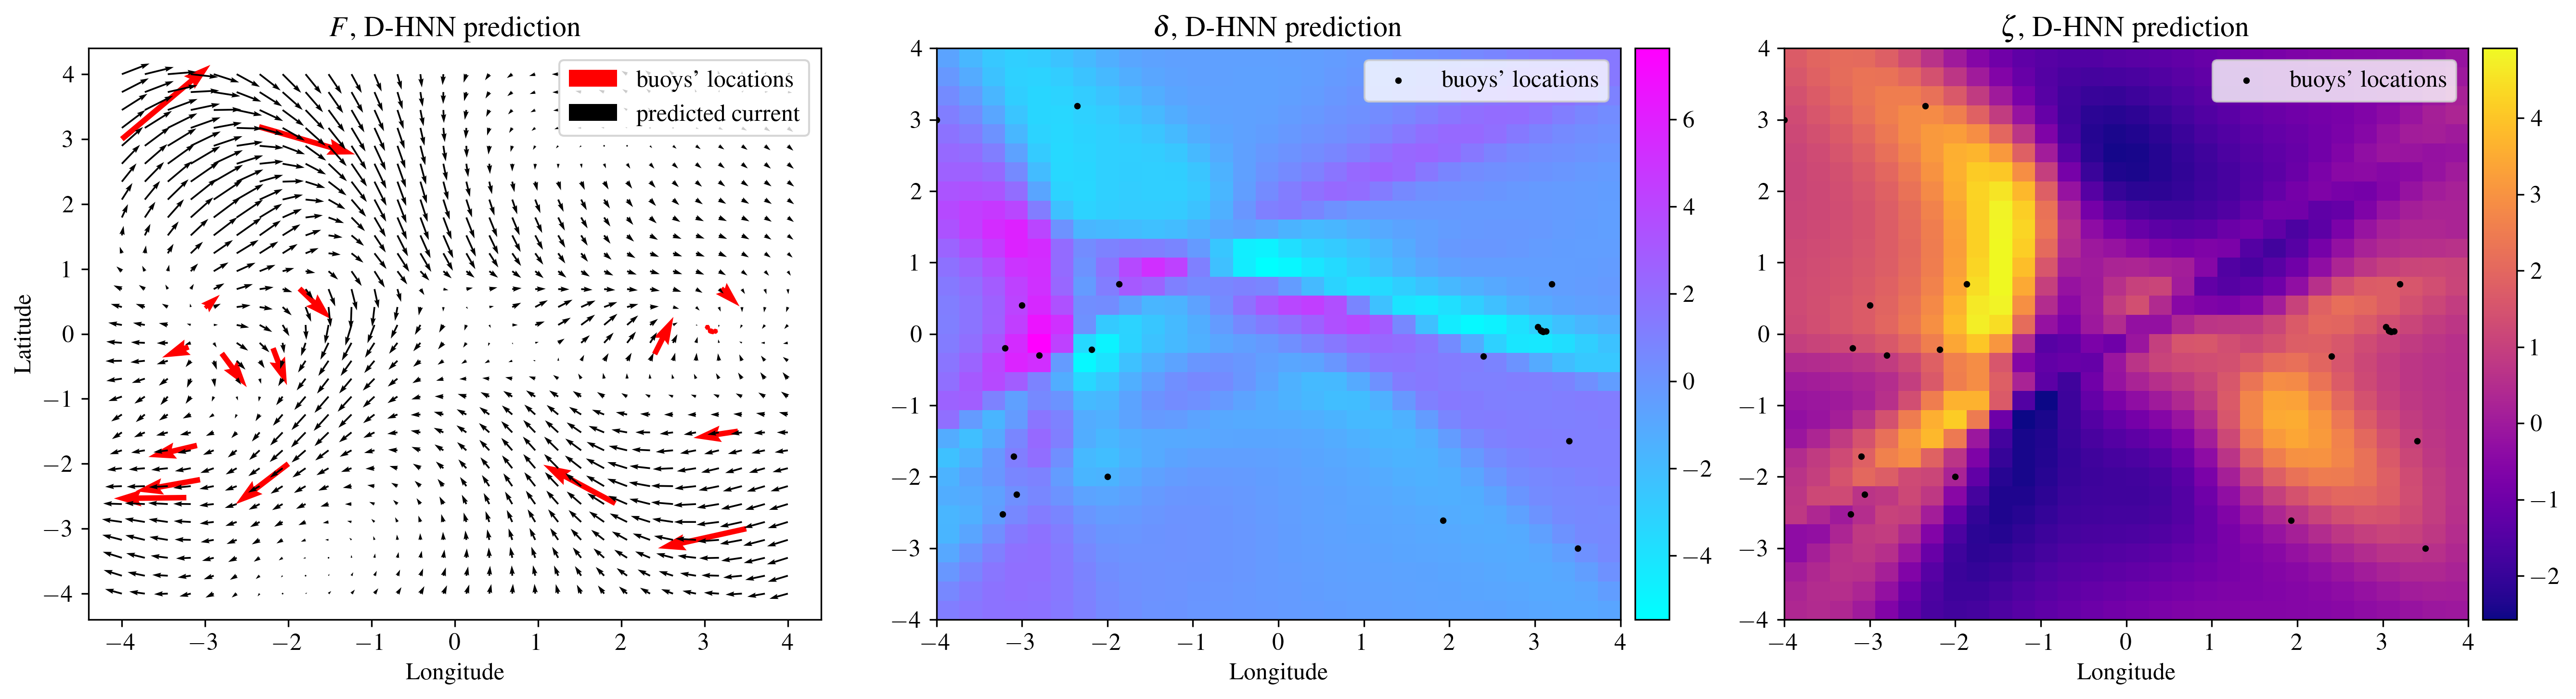

In [21]:
plot_helm.visualize_dhnn_results(X_grid, Y_grid, XY_train, UV_train, XY_test, y_hat_test, vorticity_dhnn, divergence_dhnn, cmap_div='cool', cmap_vort='plasma')

### 9. Plot for the main paper: predicted velocity field & divergence

In [22]:
plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Times"],
            "font.size": 6,
        }
    )

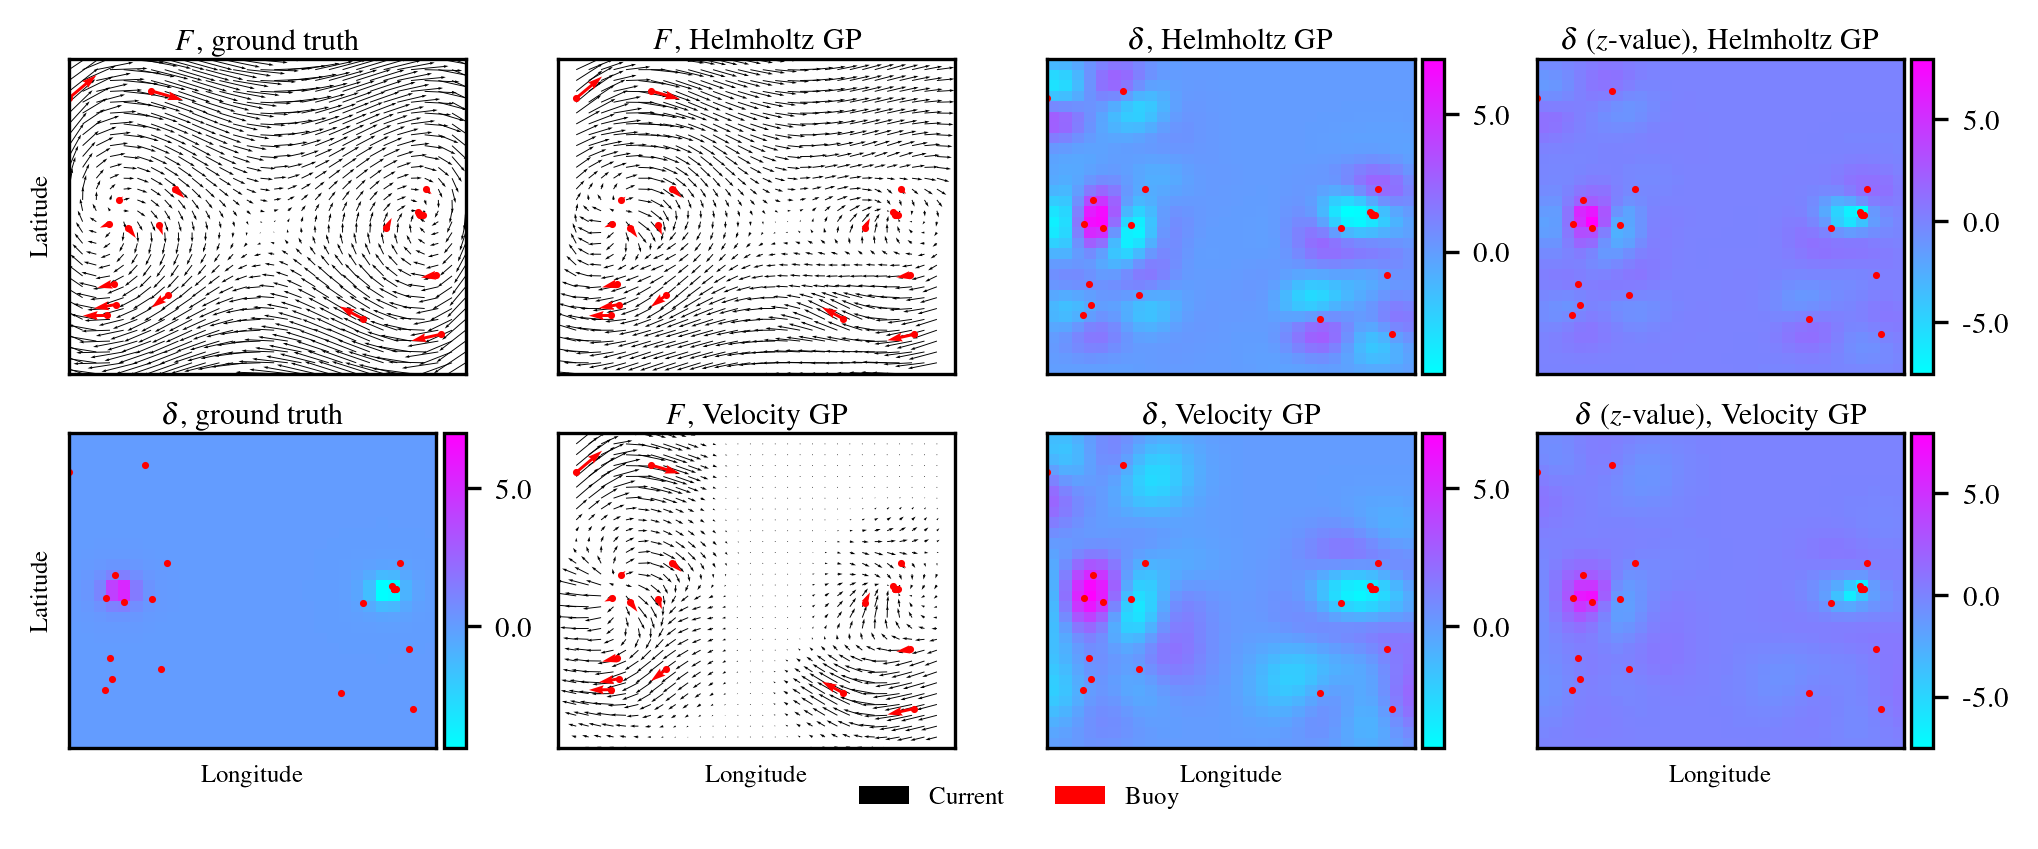

In [23]:
plot_helm.plot_results_paper(X_grid, Y_grid, XY_train, UV_train, UV_test, 
                        opt_post_mean_helm, opt_post_cov_helm, 
                        opt_post_mean_uv, opt_post_cov_uv,
                        div_grid, 
                        div_mean_helm, div_var_helm, 
                        div_mean_std, div_var_std, cmap='cool', scale=5)

### 10. Plots for the appendix

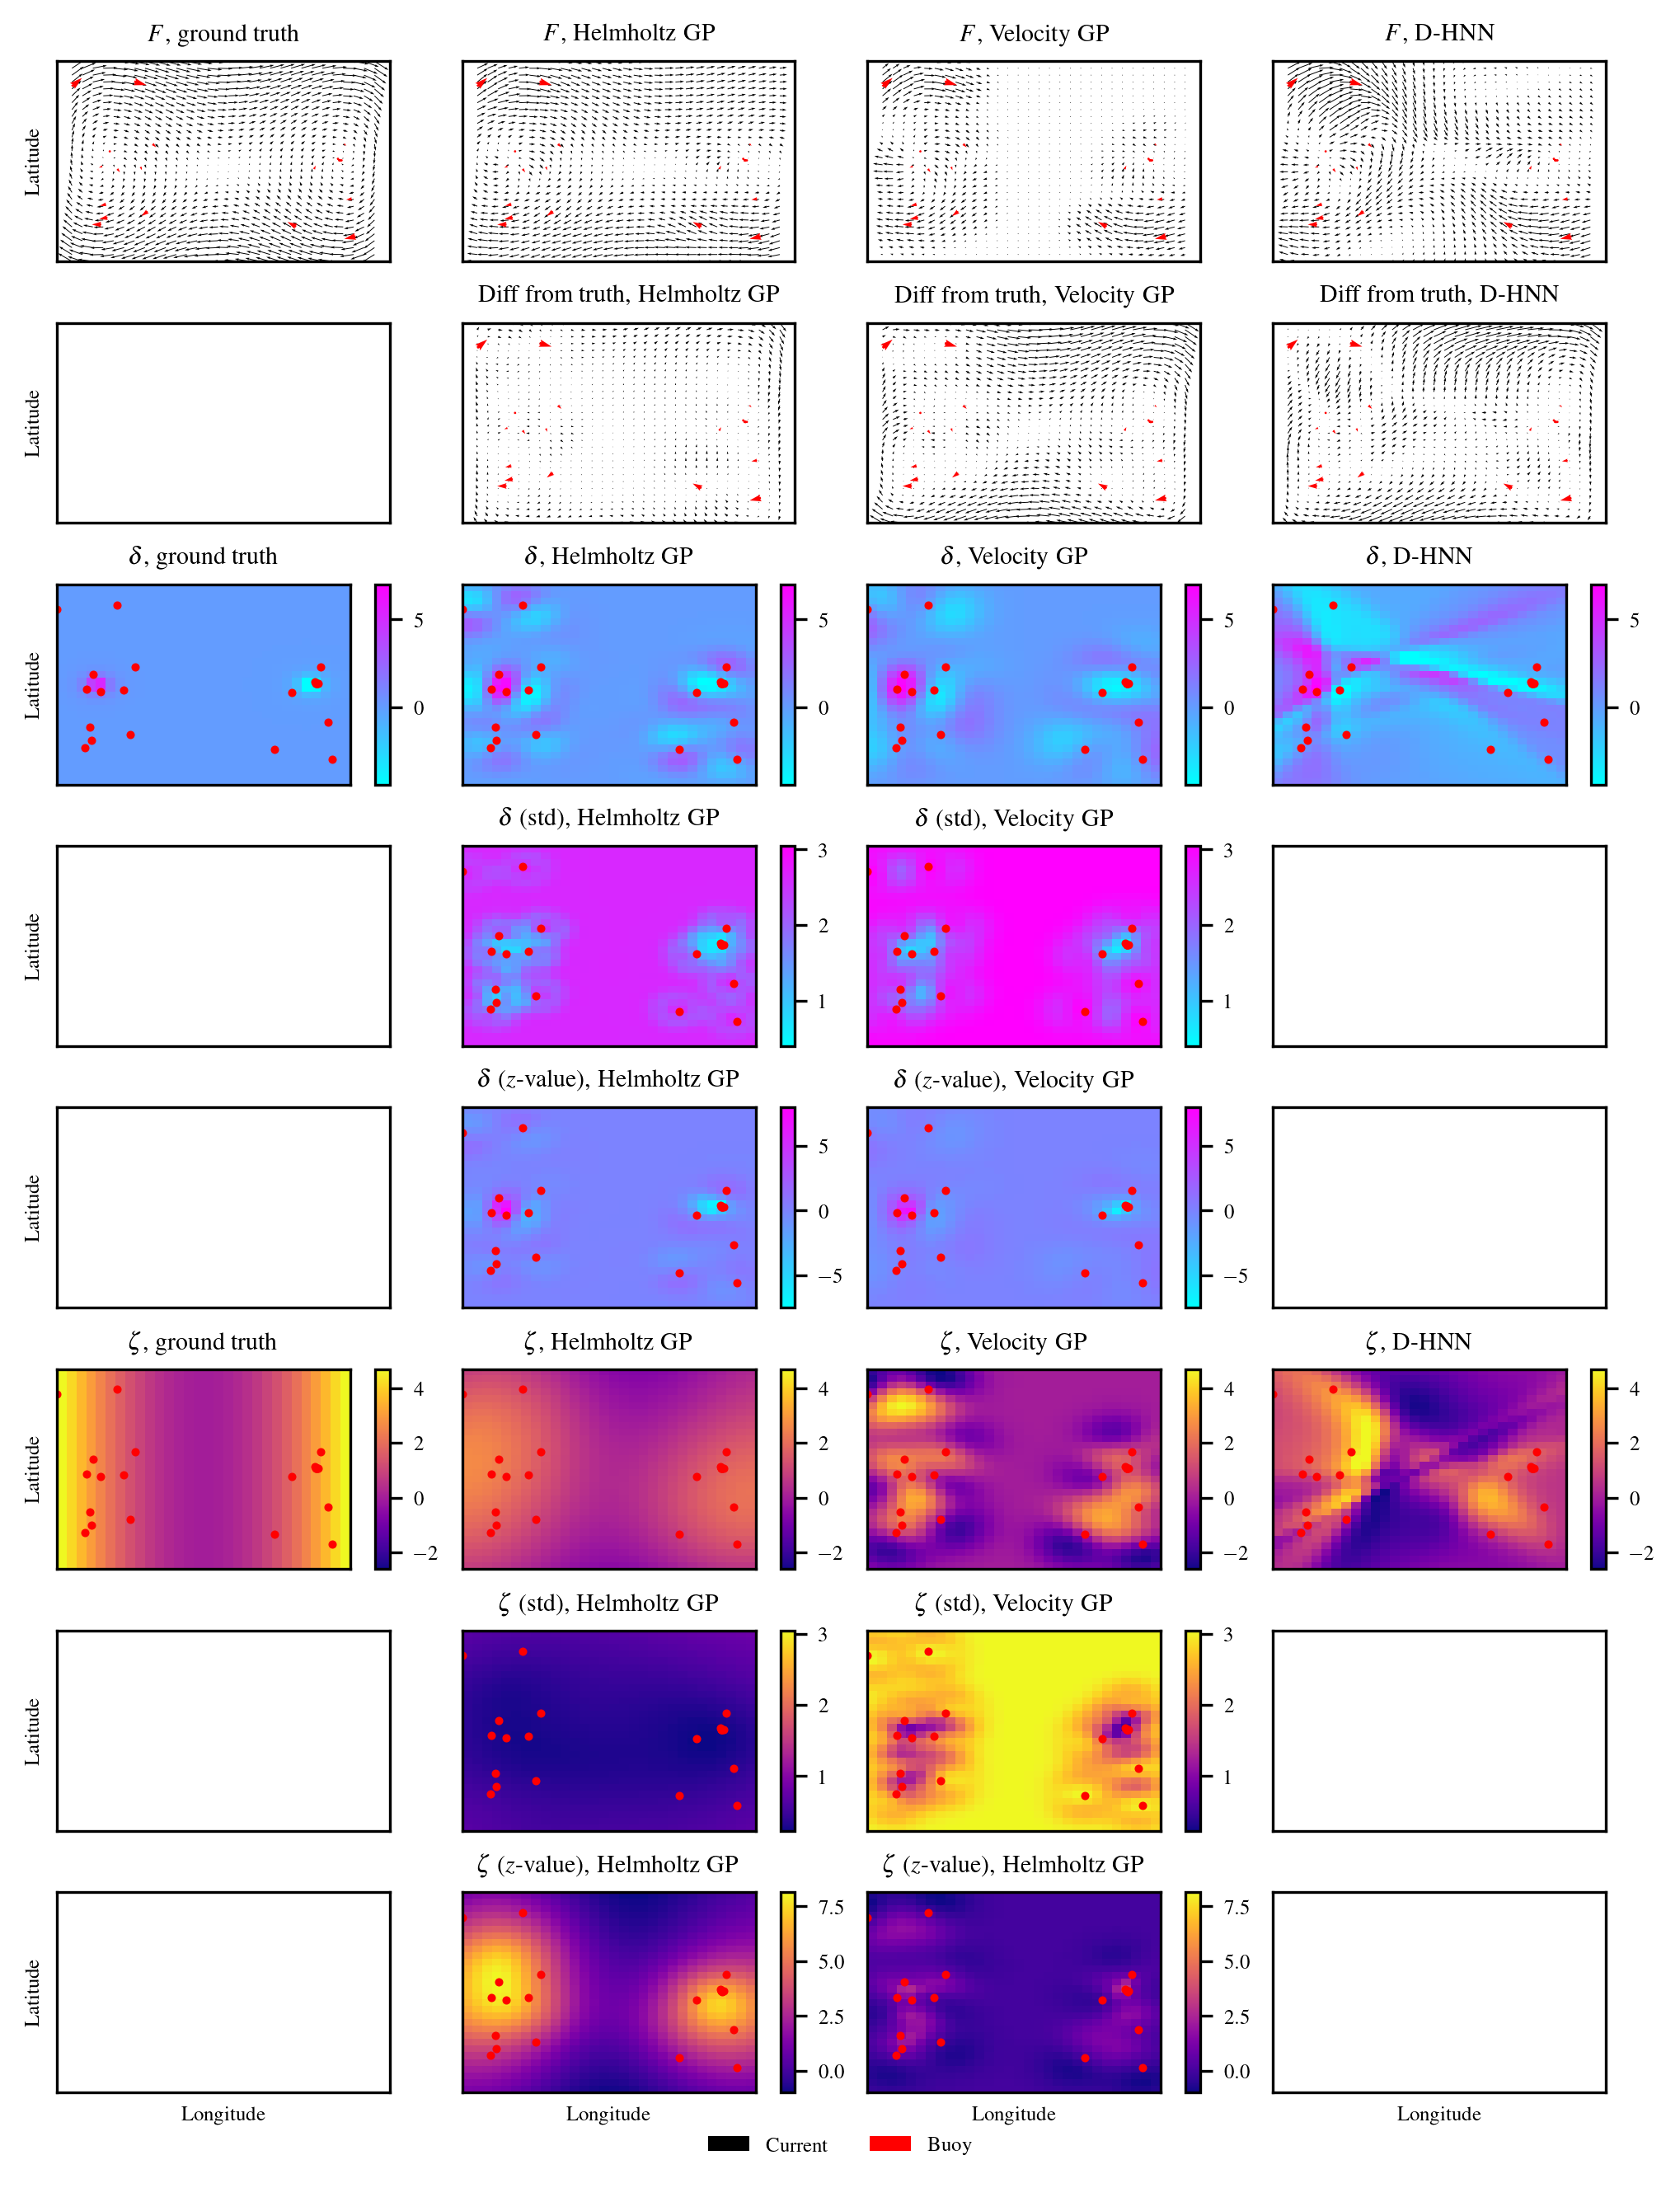

In [24]:
plot_helm.plot_results_appendix(X_grid, Y_grid, XY_train, UV_train, UV_test, 
                        opt_post_mean_helm, opt_post_cov_helm, 
                        opt_post_mean_uv, opt_post_cov_uv, 
                        div_grid, 
                        div_mean_helm, div_var_helm, 
                        div_mean_std, div_var_std, 
                        vort_grid, 
                        vort_mean_helm, vort_var_helm, 
                        vort_mean_std, vort_var_std,
                        y_hat_test, 
                        divergence_dhnn, vorticity_dhnn, 
                        cmap='cool', cmap_vort='plasma', scale=10, save_dest = "../plots_arxiv/duffing_small_appendix")


### 11. Root Mean Squared Error (RMSE) comparison - velocity predictions

We compute mean squared error of the velocity field predictions:

In [25]:
# lambda function for the MSE
mse_velocity = lambda u_truth, v_truth, u_pred, v_pred : torch.sqrt(torch.mean((u_truth - u_pred)**2 + (v_truth - v_pred)**2))

u_truth = UV_test[:,0][:,None]
v_truth = UV_test[:,1][:,None]

#helm
u_helm = opt_post_mean_helm[:XY_test.shape[0]]
v_helm = opt_post_mean_helm[XY_test.shape[0]:]
mse_helm = mse_velocity(u_truth, v_truth, u_helm, v_helm)

#standard
u_std = opt_post_mean_uv[:XY_test.shape[0]]
v_std = opt_post_mean_uv[XY_test.shape[0]:]
mse_std = mse_velocity(u_truth, v_truth, u_std, v_std)

#d-hnn
u_dhnn = y_hat_test[:,0][:,None]
v_dhnn = y_hat_test[:,1][:,None]
mse_dhnn = mse_velocity(u_truth, v_truth, u_dhnn, v_dhnn)

print(f"Helm: {mse_helm} \nStandard: {mse_std} \nD-HNN: {mse_dhnn}")


Helm: 0.9610204806252057 
Standard: 2.0510887162332705 
D-HNN: 2.142565082535176


### 12. RMSE comparison - divergence / vorticity

In [26]:
mse_div_vort = lambda truth, pred : torch.sqrt(torch.mean((truth-pred)**2))

div_grid = torch.flatten(torch.from_numpy(div_grid))[:,None]
vort_grid = torch.flatten(torch.from_numpy(vort_grid))[:,None]

#divergence
mse_helm_div = mse_div_vort(div_grid,div_mean_helm)
mse_std_div = mse_div_vort(div_grid,div_mean_std)
div_dhnn = divergence_dhnn.flatten()
mse_dhnn_div = mse_div_vort(div_grid,div_dhnn)

#vorticity
mse_helm_vort = mse_div_vort(vort_grid,vort_mean_helm)
mse_std_vort = mse_div_vort(vort_grid,vort_mean_std)
vort_dhnn = vorticity_dhnn.flatten()
mse_dhnn_vort = mse_div_vort(vort_grid,vort_dhnn)

print(f"DIVERGENCE ---\nHelm: {mse_helm_div} \nStandard: {mse_std_div} \nD-HNN: {mse_dhnn_div}")
print(f"VORTICITY ---\nHelm: {mse_helm_vort} \nStandard: {mse_std_vort} \nD-HNN: {mse_dhnn_vort}")


DIVERGENCE ---
Helm: 0.9388592512151268 
Standard: 0.9591383219394244 
D-HNN: 1.885587587931417
VORTICITY ---
Helm: 1.4000905029430506 
Standard: 2.279276698796028 
D-HNN: 2.6351381907119307
